<h1 align="center"> Tutorial: Implementing Semiring-based Layer-wise Relevance Propagation</h1>

This tutorial showcases a simple implementation mechanism for Semiring-based LRP. 
More information can be found in the report ["Extending Layer-wise Relevance Propagation with Semiring Annotation"](https://github.com/Red-Rapious/Semiring-LRP/blob/main/report/report.pdf).

We will provide an implementation for two models:
- a simple multilayer perceptron (MLP) trained on the MNIST dataset (containing `Linear` and `ReLU` layers)
- the VGG-16 network trained on ImageNet (containing `Conv2d`, `MaxPool2d`, `Linear` and `ReLU` layers)
Both models will be trained/loaded with `PyTorch`, and the Semiring LRP will be computed using `NumPy`

All the code used for the writing of the report is available [on GitHub](https://github.com/Red-Rapious/Semiring-LRP/blob/main/code); note that the implementation presented here might differ slightly for explanation purposes.

## 1. MLP on the MNIST dataset
### 1.1 Training the model

We start by importing the multiple libraries that will be used.

In [1]:
# PyTorch for model loading and training
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

# NumPy to compute Semiring LRP
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

We then load the MNIST dataset used to train our model. The MNIST dataset consists in $28\times28$ grayscale images of handwritten digits, corresponding to 10 different classes (digits 0 to 9).

In [2]:
# Load MNIST dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Prepare batches of data for training and testing

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

We can plot a training example to visualize the data that we're handling:

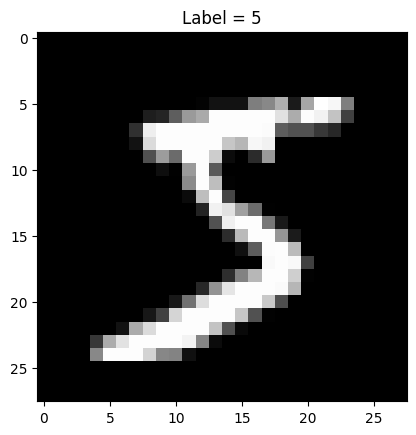

In [3]:
plt.imshow(train[0][0][0].detach().numpy(), cmap="gray")
plt.title(f"Label = {train[0][1]}")
plt.show()

We can start building and training our MLP using `PyTorch`.

In [4]:
# Select the best device to use, preferably GPU

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [5]:
# Compute the accuracy given labels and predictions
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

# Utility function to train the model
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 2

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

The model that we choose must have an input layer of size $28\times28$, and an output layer of size $10$ (one for each class). We add two hidden layers of sizes $300$ and $100$.

In [6]:
# Architecture of the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

# Build the PyTorch model
model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Training (might take some time depending on the hardware)
train_model(model, optimizer, loss_fn)

[EPOCH 1/2] Train loss: 0.35308 | Test loss: 0.14387, Test acc: 95.60%
[EPOCH 2/2] Train loss: 0.12239 | Test loss: 0.09439, Test acc: 96.93%


The model should perform relatively well (usually around 95% in just 2 epochs). We can start implementing Semiring-LRP to explain the decisions of this classifier.

### 1.2 Extracting parameters
We extract parameters of the model to be able to analyze it ourselves.

In [7]:
### Extract weights and biases of trained MLP

# we only extract Linear layers
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
# we convert weights and biases into NumPy arrays
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [8]:
### Extract input images and labels and convert it into NumPy arrays

SUBSET = 20 # we will explain 20 images from the training set

X = train.data.reshape((60000, 784)).detach().numpy()[:SUBSET]
T = train.targets.detach().numpy()[:SUBSET]

In [9]:
### We start by the forward pass
A = [X] + [None] * L # A will store the activations of each layers
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

### 1.3 Implementing the Semiring logic
So far, the approach was similar to classical LRP. We will now implement a semiring class to annotate our weights. 

For this demonstration, we will implement the boolean semiring:
$$(\{\bot, \top\}, \lor, \land, \bot, \top)$$
Conversion function $\Theta$ is threshold-based, that is:
$$
\Theta^{(l)}(x) = \begin{cases}
    \top & \textnormal{if} \quad x\geq\theta^{(l)} \\
    \bot & \textnormal{otherwise}
\end{cases}
$$
where $\theta$ is some hand-picked threshold, by default `1e-9` in the code.

Feel free to implement your own `Semiring` class by choosing the operations you want!

In [10]:
class BooleanSemiring:
    # __init__ converts a float to a Semiring element
    # this corresponds to the $\Theta$ function
    def __init__(self, x):
        self.value = True if x >= 1e-9 else False

    def __add__(self, b):
        return BooleanSemiring(self.value or b.value)

    def __mul__(self, b):
        return BooleanSemiring(self.value and b.value)
    
    def zero():
        return BooleanSemiring(0)
    
    def one():
        return BooleanSemiring(1)

    # utility function used for visualization
    def to_float(self):
        return 1 if self.value else 0
    
# we vectorize a few operations to be used later
# these are independent from the chosen semiring
initialize = np.vectorize(lambda x: BooleanSemiring.one() if x > 0 else BooleanSemiring.zero())
annotate = np.vectorize(lambda x: BooleanSemiring(x))
to_float = np.vectorize(lambda x: x.to_float())

In [11]:
# Initialize relevance R by filling the ouput vector with zeros and one (the semiring elements)
R = [None] * L + [initialize(A[L] * (T[:,None]==np.arange(10)))]

# Functions used to encapsulate LRP-0, LRP-epsilon, LRP-gamma rules
# The same functions are used for original LRP
def rho(w, l):  return w
def incr(w, l): return w

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    # classical LRP part
    w = rho(W[l], l)
    b = rho(B[l], l)
    z = incr(A[l].dot(w)+b, l)

    # compute the coefficients in the sum
    d = np.array([(A[l][image] * w.T).T/z[image] for image in range(SUBSET)])
    # annotate the weights: convert the coefficients into semiring elements
    d = annotate(d)

    # compute the sum
    R[l] = np.array([d[image] @ R[l+1][image] for image in range(SUBSET)])

# convert semiring elements back to floats for visualization
R_floats = [to_float(x) for x in R]

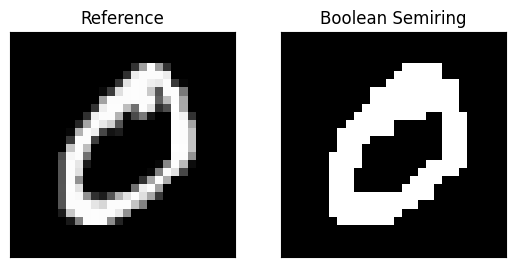

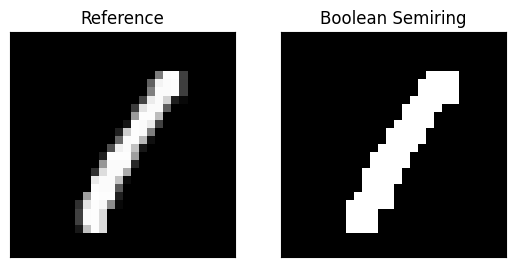

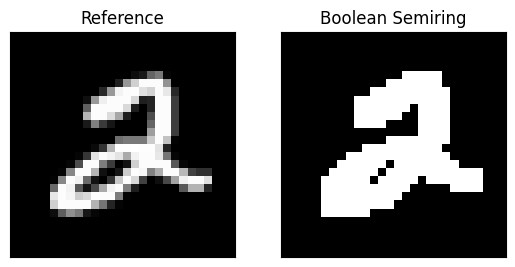

In [12]:
DIGITS = 3 # increase here to display more digit classes
for i in range(DIGITS):
    image = R_floats[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    axs[1].imshow(image, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Boolean Semiring")

    plt.show()